# Science Exam Questions with LLMs
- Will fine-tune different LLM's available on HuggingFace/Tensorflow model hubs for answering science exam questions generated by LLMs
- Must leverage GPUs as per competition rules

### **TO DO**
- Change model to one better suited to task like xlm-roberta (make sure isn't overloading memory)
- Find way to increase batch size or even use TPU if possible to decrease train time
- Add more epochs with early stopping callback
- Save current progress to the Hub or in output folder so we can reload without retraining
- Add custom classification head option

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import tensorflow as tf

To get additional training samples, we'll import 3 extra training datasets generated by Kaggle users using gpt 3.5. We'll need to get rid of the id column for the training data since the extra training examples don't have this.

In [2]:
train_data_links = ['/kaggle/input/kaggle-llm-science-exam/train.csv',
                   '/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv',
                   '/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv',
                   '/kaggle/input/15k-high-quality-examples/15k_gpt3.5-turbo.csv']

In [3]:
RANDOM_STATE = 123

# Load training data, you need to get rid of id which you don't need
train_df = pd.concat([pd.read_csv(data) for data in train_data_links])
train_df[['prompt', 'A', 'B', 'C', 'D', 'E', 'answer']] = train_df[['prompt', 'A', 'B', 'C', 'D', 'E', 'answer']].astype(str)
train_df.drop('id', inplace = True, axis = 1)

# Import test set from Kaggle
test_df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')    # Change to your test file path

# Load additional training data
train_extra_df = pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv')
train_extra_6000_df = pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv')

# Further split into train, validation and test
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)


We're going to augment the test_df to have an answers column. This will allow us to use the same preprocessing and tokenizing functions. We end up taking them off and not using them anyway until an accuracy metric is calculated in the training phase. 

In [4]:
# Augment the test_df to have an answers column with just all "A"
test_df['answer'] = 'A'

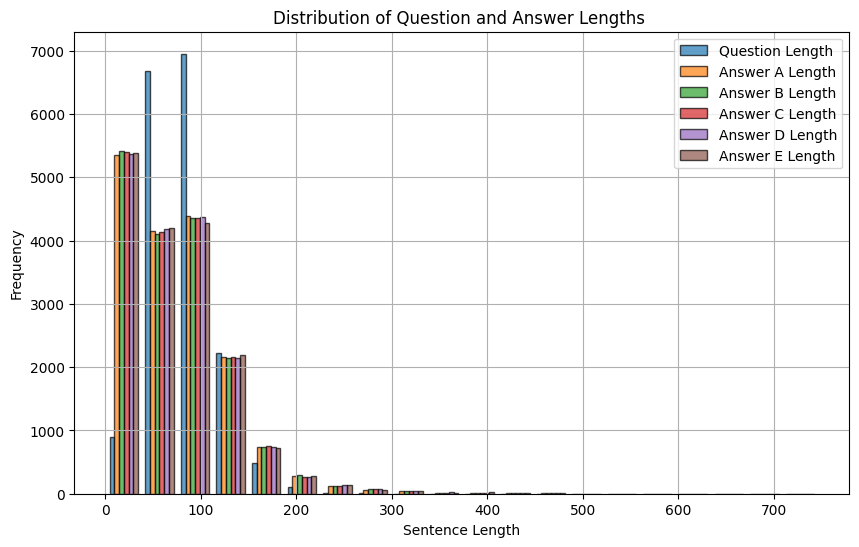

In [5]:
analysis = train_df.copy()

# With extra data, some answers are numeric, so cast to string to be safe
analysis["question_length"] = analysis["prompt"].apply(lambda x : len(x))
analysis["answer_A_length"] = analysis['A'].apply(lambda x : len(str(x)))
analysis["answer_B_length"] = analysis['B'].apply(lambda x : len(str(x)))
analysis["answer_C_length"] = analysis['C'].apply(lambda x : len(str(x)))
analysis["answer_D_length"] = analysis['D'].apply(lambda x : len(str(x)))
analysis["answer_E_length"] = analysis['E'].apply(lambda x : len(str(x)))

plt.figure(figsize=(10, 6))
plt.hist([analysis['question_length'], 
          analysis['answer_A_length'], 
          analysis['answer_B_length'],
          analysis['answer_C_length'],
          analysis['answer_D_length'],
          analysis['answer_E_length']], 
          bins=20, edgecolor='black', alpha=0.7, 
          label=['Question Length','Answer A Length', 'Answer B Length', 'Answer C Length',
                'Answer D Length', 'Answer E Length'])
plt.title('Distribution of Question and Answer Lengths ')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### Tokenizing Text
- Get Model from HuggingFace hub. However, this competition doesn't let us use the internet, so we need to download weights locally.
- Preprocess
- Tokenize

In [6]:
# Need to import models locally from HuggingFace because we can't use internet
from transformers import AutoTokenizer, AutoModelForMaskedLM

MODEL_DIR = "/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/"
model_checkpoint = MODEL_DIR + 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
# Convert dataframe into HuggingFace Datasets for ease of use
from datasets import Dataset, DatasetDict
# Create datasets for each dataframe
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)
# Add to dataset dict just in case it's useful. Only do train and val here

train_val_ds = DatasetDict({'train': train_ds, 'val': val_ds})

In [8]:
train_val_ds

DatasetDict({
    train: Dataset({
        features: ['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', '__index_level_0__'],
        num_rows: 17360
    })
    val: Dataset({
        features: ['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', '__index_level_0__'],
        num_rows: 4340
    })
})

In [9]:
# Explore dataset a bit more
def show_one(example):
    print(f"Prompt: {example['prompt']}")
    print(f"  A - {example['A']}")
    print(f"  B - {example['B']}")
    print(f"  C - {example['C']}")
    print(f"  D - {example['D']}")
    print(f"\nAnswer: {example['answer']}")
    return None
show_one(train_val_ds["train"][0])

Prompt: How many officers and men were officially awarded the Victoria Cross between the Indian Mutiny in 1857 and the beginning of the Second Boer War?
  A - No officers and men were officially awarded the Victoria Cross during this period as the royal warrant did not contain a specific clause for posthumous awards.
  B - Six officers and men were officially awarded the Victoria Cross during this period, as their names were published in the London Gazette with a memorandum stating they would have been awarded the VC had they survived.
  C - The exact number of officers and men officially awarded the Victoria Cross during this period is unknown, as no details of the presentations are known.
  D - The original royal warrant contained a specific clause for posthumous awards, resulting in numerous officers and men being officially awarded the Victoria Cross during this period.

Answer: B


### Explanation of data:
- first_sentences: A list of 5 lists. Each list is a list of all of the prompts from the dataframe. first_sentences[0] is the first set of all of the prompts. first_sentences[0][0] is the first question in the first questions list.
- second_sentences: A list of 5 lists. Each list is a list of all of the answers for A, answers for B, etc.

### Goal:
- We need to pair these so that we have prompt[0] with A, prompt[0] with B, etc.

In [10]:
# Preprocess labels into format readable by tokenizer
answer_choices = ["A", "B", "C", "D", "E"]
answer_indices = list(range(5))

# Create dicts of A:0,... and 0:A...
choice_to_index = {choice: index for choice, index in zip(answer_choices, answer_indices)}
index_to_choice = {index: choice for choice, index in zip(answer_choices, answer_indices)}

In [11]:
# Function to get tokenized dataset. Should return dataset with tokenized pairs and labels
def get_tokenized_ds(ds):
    '''
    ds = input dataset with prompt, A->E, and answer
    tokenizer = tokenizer from HF/TF
    data_name = 'val', 'train', or 'test'
    '''

    # Creates list of 5 elements, each of which is a series containing all of the prompts. 5 copies of prompt column
    first_sentences = [ds['prompt']]*5
    # Create list of 5 series, one for each of A-E answers to prompts
    second_sentences = []
    for choice in answer_choices:
        second_sentences.append(ds[choice])
    
    # Feed pairs into tokenizer. Returns dict of input_ids, attention_mask, token_type_ids
    tokenized_ds = tokenizer(
        text=first_sentences, # No need to cast to list since it already is one
        text_pair=second_sentences,
        # padding='max_length', # No padding just yet
        truncation=True,
        #max_length=MAX_LENGTH, # No max length just yet
        return_attention_mask=True,
        return_token_type_ids=True,
        #return_tensors='tf' # Using HF datasets here rather than TF tensors just yet
    )

    tokenized_ds['label'] = choice_to_index[ds['answer']]

    return tokenized_ds

In [12]:
# With dataset, you preprocess via a map on each entry rather than returning df
tokenized_train_val_ds = train_val_ds.map(get_tokenized_ds,
                                          batched=False,
                                          remove_columns=['prompt', 'A','B','C','D','E','answer'])

  0%|          | 0/17360 [00:00<?, ?ex/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/4340 [00:00<?, ?ex/s]

In [13]:
tokenized_train_val_ds

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 17360
    })
    val: Dataset({
        features: ['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 4340
    })
})

We will pad and bactch the data separately with some code from HF, a class called DataCollatorForMultipleChoice. This will dynamically pad the input_ids so that they are padded to the max length in each batch rather than the whole dataset.

NOTE: Whatever is passed through the call of this class must not have any of the old features that aren't going into the model directly.

In [14]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import (
    PreTrainedTokenizerBase,
    PaddingStrategy,
)
from typing import Optional, Union

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    When run on this set should return (batch_size * 5) x seq_length size
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)]
            for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="np",
        )

        # Un-flatten
        batch = {
            k: tf.reshape(v, (batch_size, num_choices, -1)) for k, v in batch.items()
        }
        # Add back labels
        batch["labels"] = tf.convert_to_tensor(labels, dtype=tf.int64)
        return batch

# Declare data collator object
data_collator = DataCollatorForMultipleChoice(tokenizer)

In [15]:
# Declare model using auto model for mcq's package from HF
from transformers import TFAutoModelForMultipleChoice

model = TFAutoModelForMultipleChoice.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifie

In [16]:
# Create name and id for adding the trained model to HF account for later reloading
model_name = model_checkpoint.split('/')[-1] # Start at the model name
push_to_hub_model_id = f'{model_name}-finetuned-science-exam'

# Set some initial hyperparameter values
LEARNING_RATE = 5e-5
BATCH_SIZE = 16
NUM_TRAIN_EPOCHS = 2
WEIGHT_DECAY = 0.01
MAX_INPUT = 384

### Sanity Checks on our Process So Far

In [17]:
# Test to see if the collator works properly to create a batch on a list of features
accepted_keys = ["input_ids", "attention_mask", "label"]

# Create list of features to pass to our collator's call method
features = [
    {k: v for k, v in tokenized_train_val_ds["train"][i].items() if k in accepted_keys}
    for i in range(10)
]

# Instantiate collator and pass the list of features to its __call_
batch = DataCollatorForMultipleChoice(tokenizer)(features)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
# This should return nothign to make sure only valid inputs to model are in our ds
tokenized_train_val_ds["train"].features["attention_mask"].feature.feature

Value(dtype='int8', id=None)

Check to see what comes out of our tokenized inputs when decoded. The following should print out a list of padded (with other tokens) prompts with each of the 5 possible answer choices. 
- batch['input_ids'][1][i] should yield the 1st element of the batch and i will be the prompt with choice i.

In [19]:
# Check to see what some of our tokenized inputs decode properly
# Should return list of question with 5 possible answers
[tokenizer.decode(batch["input_ids"][1][i].numpy().tolist()) for i in range(5)]

['[CLS] what was the focus of the mont tremblant conference organized by the institute of pacific relations in december 1942? [SEP] the waging of world war ii in the pacific theatre and the structure of international affairs after the war with a focus on the welfare of countries in east asia and southeast asia. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] what was the focus of the mont tremblant conference organized by the institute of pacific relations in december 1942? [SEP] the eradication of poverty in countries in east asia and southeast asia. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] what was the focus of the mont tremblant conference organized by the institute of pacific relations in december 1942? [SEP] the establishment of a unified economic system in countries in e

Now we can check to make sure the original dataset has the same question and answer combos.

In [20]:
show_one(train_val_ds["train"][1])

Prompt: What was the focus of the Mont Tremblant Conference organized by the Institute of Pacific Relations in December 1942?
  A - The waging of World War II in the Pacific theatre and the structure of international affairs after the war with a focus on the welfare of countries in East Asia and Southeast Asia.
  B - The eradication of poverty in countries in East Asia and Southeast Asia.
  C - The establishment of a unified economic system in countries in East Asia and Southeast Asia.
  D - The exploration of sustainable development practices in countries in East Asia and Southeast Asia.

Answer: A


### Training our Model

Looks good! 
- We have now preprocessed our prompts and answer choices to be paired, tokenized all of our inputs for input into bert-type models, and created a HuggingFace dataset object with our train and val sets. 

- Next, we use our data collator and the HF model.pre_tf_dataset instead of TF's native from_tensor_slices method to create something that can be put into tensorflow

In [21]:
# Use HF model prepare_tf_dataset. This takes care of batch sizing and shuffling and padding
train_tf = model.prepare_tf_dataset(
    tokenized_train_val_ds["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator, # pass collator to do our dynamic padding in each batch
)

val_tf = model.prepare_tf_dataset(
    tokenized_train_val_ds["val"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

train_tf

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

The above yielded a Prefetch dataset with two elements to a dict. The first is the input_ids and attention mask. The second is a tensor of the labels.

Next:
- Use HF create optimizer to dynamically pick the optimizer based on the chosen task.
- Set the HF equivalent of "steps-per-epoch" which here is total_train_steps


In [22]:
from transformers import create_optimizer

# Set the total number of training steps that will occur
total_train_steps = (len(tokenized_train_val_ds['train']) // BATCH_SIZE)*NUM_TRAIN_EPOCHS

# Create an optimizer and get a schedule dynamically from HF built in classes
optimizer, schedule = create_optimizer(init_lr = LEARNING_RATE,
                                       num_warmup_steps=0, # Turn off "warm up phase"
                                       num_train_steps = total_train_steps)

In [23]:
# Compile our TF model without specifying a loss as it will use "internal loss" function in HF
model.compile(optimizer=optimizer,
              metrics = ['accuracy'],
             )

# Print summary of the model architecture
model.summary()

Model: "tf_distil_bert_for_multiple_choice"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 66,954,241
Trainable params: 66,954,241
Non-trainable params: 0
_________________________________________________________________


If not using a custom classification head, we see a simple architecture of the pre-trained model, some dropout, and then a classifier head.

TODO --> Pick a new model for this task that doesn't need multi language to make sure architecture works. Right now we're using too much memory for Kaggle.

In [24]:
# Get callbacks packages
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

#tensorboard_callback = TensorBoard(log_dir="./mc_model_save/logs")

#push_to_hub_callback = PushToHubCallback(
#    output_dir="/kaggle/working/model", 
#    tokenizer=tokenizer, 
#    hub_model_id="reggiebain/xlm-roberta-large-xnli-finetuned-science-exam"
#)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   save_weights_only=True,
                                   save_best_only=True,
                                   monitor="val_loss")

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True)

#callbacks = [tensorboard_callback, push_to_hub_callback, early_stopping]
callbacks = [early_stopping, model_checkpoint]

model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=NUM_TRAIN_EPOCHS,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/2
1085/1085 - 18609s - loss: 1.4164 - accuracy: 0.3975 - val_loss: 1.3600 - val_accuracy: 0.4406 - 18609s/epoch - 17s/step
Epoch 2/2
1085/1085 - 19537s - loss: 1.0416 - accuracy: 0.5892 - val_loss: 1.4645 - val_accuracy: 0.4369 - 19537s/epoch - 18s/step


In [25]:
val_loss, val_accuracy = model.evaluate(val_tf)

272/272 [==============================] - 1397s 5s/step - loss: 1.4645 - accuracy: 0.4369


In [26]:
# Save the model so we can START HERE later
model.save('/kaggle/working/model_checkpoint')

# If we've already trained, load the model
#model = tf.keras.models.load_model('<model path>')

In [27]:
print(f'{val_loss=}\n{val_accuracy=}')

val_loss=1.4644861221313477
val_accuracy=0.4368663728237152


### Inference
- Preprocess and tokenize test dataset
- Feed into model and get logits
- Use argmax to get most probable outcome
- Make look like submission file

In [28]:
tokenized_test_ds = test_ds.map(get_tokenized_ds,
                                remove_columns=['prompt', 'A','B','C','D','E', 'answer'])
tokenized_test_ds

  0%|          | 0/200 [00:00<?, ?ex/s]

Dataset({
    features: ['id', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})

In [29]:
# Prepare a tensorflow compatible tensor from test dataset
test_tf = model.prepare_tf_dataset(
    tokenized_test_ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
test_tf

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Feeding the test_tf dataset into our model should return a TFMultipleChoiceModelOutput object, which contains logits for each of the 5 answer choices. We'll need to get the max arg as well as convert these by index back into A-E choices.

In [30]:
# Feed tokenized/preprocessed test set into the model. Returns TFMultipleChoiceModelOutput
predictions = model.predict(test_tf)

13/13 [==============================] - 104s 8s/step


Now, create a function to convert our predictions, which are a TFMultipleChoiceModelOutput object, into a submission file. We need to:
1. Get the logits from each prediction row
2. Sort them in descending order
3. Use numpy to convert the indices into letters A->E

In [31]:
def get_output_from_predictions(predictions):
    # Get the logits from the TFMultipleChoiceModelOutput object
    logits = predictions.logits
    # Get the indices that would sort the logits for each row in descending order (hence the -)
    sorted_logit_indices = np.argsort(-logits, axis=1)
    # Get the elements of an array A,B,C,D corresponding to the sorted logits
    logits_as_letters = np.array(answer_choices)[sorted_logit_indices]
    
    # Create predictions as a string
    logits_as_string = [' '.join(row) for row in logits_as_letters[:, :3]]
    
    return logits_as_string

In [32]:
# Add predictions to the test_df using the function above
test_df['prediction'] = get_output_from_predictions(predictions)

# Keep only the id and predctions columns for submission. Don't worry about the index
submission = test_df[['id', 'prediction']]
submission

,id,prediction
0,0,D B A
1,1,A E D
2,2,A C B
3,3,C B E
4,4,D A B
...,...,...
195,195,C A E
196,196,C B A
197,197,B A E
198,198,C B D


In [33]:
# Prepare final submission csv
submission.to_csv('submission.csv', index=False)